## Description:
Run many models looking at:
1 - BMI and omic variables longitudinally 
2 - BMI and variable changes from BL-6m and 6m-12m

In [5]:
import pandas as pd
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
import glob
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib as mpl
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats
from joblib import dump
sns.set_context("poster")
mpl.rcParams['figure.figsize'] = (11,8)

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from em_utils import *

# test and train set directories for input data
longitudinal_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/5.combined/"
delta_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/zachs_rerun/drift_fs/csv/all_omic_processed_data/deltas/"
clin_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/clinical/transformed/aim2/merf_ready"
# Where hyperparameter training results are
delta_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/6.two_timepoints_deltas"
long_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/5.combined"
func_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/3.functional"
taxa_long_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/2.taxa"
clinical_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/1.clinical"
micom_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/4.micom"

In [67]:
# test and train longitudinal files 
test_all = pd.read_csv(os.path.join(longitudinal_dir, 'feb20_test_merged_all_omics_raw_meta.csv'))  
train_all = pd.read_csv(os.path.join(longitudinal_dir, 'feb20_training_merged_all_omics_raw_meta.csv'))  
print("test long shape = ", test_all.shape)
print("train long shape = ", train_all.shape)
print("test longitudinal: ", test_all.columns)
print("train longitudinal: ", train_all.columns)

# test and train delta files 
test_delta = read_data(delta_dir, "feb20_all_delta_test.csv")
train_delta = read_data(delta_dir, "feb20_all_delta_train.csv")
print("test delta shape = ", test_delta.shape)
print("train delta shape = ", train_delta.shape)
print("test delta: ", test_delta.columns)
print("train delta: ", train_delta.columns)

# hyperparameter training files 
delta_df = pd.read_csv(os.path.join(delta_df_dir, 'jan30_2times_all_omic_deltas_BMI_remove_time_var_imputed_swapped.csv'))
long_df = pd.read_csv(os.path.join(long_df_dir, 'feb20_params_fine_tuning_results_all_omics.csv'))
func_df = pd.read_csv(os.path.join(func_df_dir, 'dec6_magggie_params_fine_tuning_results_raw_functional.csv'))
taxa_df = pd.read_csv(os.path.join(taxa_long_df_dir, 'dec6_maggie_params_tuning_raw_taxa_oob.csv'))
micom_df = pd.read_csv(os.path.join(micom_df_dir, 'dec6_maggie_params_fine_tuning_results_raw_micom.csv'))
meta_df = pd.read_csv(os.path.join(clinical_df_dir, 'dec5_maggie_params_tuning_raw_clinical_oob.csv'))
#meta_df = pd.read_csv('/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/1.clinical/fine_tuning_results_raw_clinical.csv')

test long shape =  (66, 557)
train long shape =  (280, 557)
test longitudinal:  Index(['record_id', 'subject_id', 'randomized_group', 'cohort_number', 'sex',
       'race', 'age', 'outcome_BMI_fnl', 'Glucose', 'HOMA_IR',
       ...
       'g__Ventrisoma', 'g__Clostridium_Q_135853', 'g__Clostridium_Q_135822',
       'g__Porcincola', 'g__Copromonas', 'g__Ventrimonas', 'g__Dorea_A',
       'g__Massilistercora', 'all_samples', 'bmi_prs'],
      dtype='object', length=557)
train longitudinal:  Index(['record_id', 'subject_id', 'randomized_group', 'cohort_number', 'sex',
       'race', 'age', 'outcome_BMI_fnl', 'Glucose', 'HOMA_IR',
       ...
       'g__Ventrisoma', 'g__Clostridium_Q_135853', 'g__Clostridium_Q_135822',
       'g__Porcincola', 'g__Copromonas', 'g__Ventrimonas', 'g__Dorea_A',
       'g__Massilistercora', 'all_samples', 'bmi_prs'],
      dtype='object', length=557)
test delta shape =  (60, 548)
train delta shape =  (222, 548)
test delta:  Index(['subject_id', 'randomized_group

In [64]:
print("test longitudinal: ", list(test_all.columns))
print("train longitudinal: ", list(train_all.columns))
print("test subject_id: ", test_all['subject_id'].tolist())  # Print subject_id from test_all
print("train subject_id: ", train_all['subject_id'].tolist())  # Print subject_id from train_all

test longitudinal:  ['record_id', 'subject_id', 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'outcome_BMI_fnl', 'Glucose', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid', 'time', 'sample_id', 'proton', 'Diacetyl', 'Butyrate', 'Formate', 'acetone', 'X2.methylbutyrate', 'Valeric.Acid', 'Methane', 'X1.4.Dihydroxy.2.naphthoate', 'X2.Oxoglutarate', 'Pyruvate', 'D.lactate', 'L.lactate', 'laurate', 'Phenol', 'L.Carnitine', 'Isopropanol', 'p.Cresol', 'O2', 'X1.Propanol', 'butanol', 'Propanal', 'X4.hydroxyphenylacetate', 'X.S..propane.1.2.diol', 'Propane.1.3.diol', 'R_R__2_3_Butanediol', 'Oxaloacetate', 'sulfate', 'octadecenoate..n.C18.1.', 'o.Succinylbenzoate', 'Thymidine', 'Reduced.riboflavin', 'Riboflavin', 'X2.Hydroxyphenylacetate', 'Sulfite', 'thiosulfate.2..', 'X.3.4.dihydroxyphenyl.acetate', 'Diphosphate', 'trimethylamine', 'glycine.betaine', 'Choline', 'Trimethylamine.N.oxide', 'Isochorismate', 'Inosine', 'xanthosine', 'Hypoxant

### Longitudinal BMI first 

In [ ]:
# Drop some columns 
train_long = train_all.drop(['Unnamed: 0_merged_data',
                    'sample_id','subject_id', 'all_samples_y', 'record_id','time_y'], 
                    axis=1)

test_long = test_all.drop(['Unnamed: 0_merged_data',
                    'sample_id','subject_id', 'all_samples_y', 'record_id',
                    'time_y'], 
                    axis=1)
print("test long shape = ", test_long.shape)
print("train long shape = ", train_long.shape)

test_long.rename(columns={'outcome_BMI_fnl': 'outcome_bmi_fnl'}, inplace=True)
train_long.rename(columns={'outcome_BMI_fnl': 'outcome_bmi_fnl'}, inplace=True)

print("test longitudinal: ", list(test_long.columns))
print("train longitudinal: ", list(train_long.columns))

In [50]:
# Find the column numbers for "proton" and "Carbon.dioxide" in train_set
proton_column = train_long.columns.get_loc("proton")
carbon_dioxide_column = train_long.columns.get_loc("Carbon.dioxide")
proton_column_test = test_long.columns.get_loc("proton")
carbon_dioxide_column_test = test_long.columns.get_loc("Carbon.dioxide")

# Columns to KEEP for only meta 
basic = ['all_samples','outcome_bmi_fnl', 'time','age','sex']
meta_keep = ['all_samples','outcome_bmi_fnl', 'time', 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid']
only_grs = ['all_samples','outcome_bmi_fnl', 'bmi_prs', 'time']
only_taxa = ['all_samples','outcome_bmi_fnl', 'time'] + [col for col in train_long.columns if col.startswith("g__")]
only_micom = ['all_samples','outcome_bmi_fnl', 'time'] + [col for col in train_long.columns if col in train_long.columns[proton_column:carbon_dioxide_column+1]]

# Create a set of all columns to EXCLUDE
exclude_columns = set(meta_keep + only_grs + only_taxa + only_micom)
only_pathway = ['all_samples', 'outcome_bmi_fnl', 'time'] + [col for col in train_long.columns if col not in exclude_columns]

# Columns to KEEP for only meta + GRS
meta_grs = ['all_samples','outcome_bmi_fnl', 'time','randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid', 'bmi_prs']
# Columns to KEEP for only meta + GRS + taxa
meta_grs_taxa = meta_grs + [col for col in train_long.columns if col.startswith("g__")]
meta_grs_taxa_test = meta_grs + [col for col in test_long.columns if col.startswith("g__")]
# Columns to KEEP for only meta + GRS + taxa + pathway/functional 
meta_grs_taxa_functional = meta_grs_taxa + [col for col in train_long.columns if col not in train_long.columns[proton_column:carbon_dioxide_column+1]]
meta_grs_taxa_functional_test = meta_grs_taxa + [col for col in test_long.columns if col not in test_long.columns[proton_column_test:carbon_dioxide_column_test+1]]
# Columns to DROP for only GRS + taxa + pathway/functional + micom (no meta)
all_but_meta = ['randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid']

## Basic and each layer 
grs_basic = basic + meta_grs
taxa_basic = basic + only_taxa
micom_basic = basic + only_micom
path_basic = basic + only_pathway

# 1.0 Only Basic 

In [ ]:
train_l = train_long[basic]
test_l = test_long[basic]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long/feb20"
r2_out = 'r2_only_basic_merf_bmi_long_feb20.png'
feature_imp_out = 'fi_only_basic_merf_bmi_long_feb20.png'
results_filename = 'merf_results_long_only_basic_feb20.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['time'])

print("---------- Run MERF models ----------")
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## 1.1 Trying Meta from omic DF

PTEV is the best one 
First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

In [ ]:
train_l = train_long[meta_keep]
test_l = test_long[meta_keep]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long/feb20/"
r2_out = 'r2_only_meta_merf_bmi_long_feb20.png'
feature_imp_out = 'fi_only_meta_merf_bmi_long_feb20.png'
results_filename = 'merf_results_long_only_meta_feb20.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['time'])

print("---------- Run MERF models ----------")

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## Only PRS

In [ ]:
train_l = train_long[only_grs]
test_l = test_long[only_grs]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long/feb20"
r2_out = 'r2_only_grs_merf_bmi_long_feb20.png'
feature_imp_out = 'fi_only_grs_merf_bmi_long_feb20.png'
results_filename = 'merf_results_long_grs_feb20.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['time'])
print("---------- Run MERF models ----------")
#r2_run2, fi_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## Only Taxa

In [ ]:
train_l = train_long[only_taxa]
test_l = test_long[only_taxa]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long/feb20"
r2_out = 'r2_only_taxa_merf_bmi_long_feb20.png'
feature_imp_out = 'fi_only_taxa_merf_bmi_long_feb20.png'
results_filename = 'merf_results_long_only_taxa_feb20.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['time'])
print("---------- Run MERF models ----------")
#r2_run2, fi_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df, output_dir, r2_out, feature_imp_out, results_filename, time_new)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## Only Micom

In [ ]:
train_l = train_long[only_micom]
test_l = test_long[only_micom]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long/feb20"
r2_out = 'r2_only_micom_merf_bmi_long_feb20.png'
feature_imp_out = 'fi_only_micom_merf_bmi_long_feb20.png'
results_filename = 'merf_results_long_only_micom_feb20.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['time'])
print("---------- Run MERF models ----------")
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## Only pathway data

In [ ]:
train_l = train_long[only_pathway]
test_l = test_long[only_pathway]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long/feb20"
r2_out = 'r2_only_pathway_merf_bmi_long_feb20.png'
feature_imp_out = 'fi_only_pathway_merf_bmi_long_feb20.png'
results_filename = 'merf_results_long_only_pathway_feb20.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['time'])

print("---------- Run MERF models ----------")
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## 1.2 trying Meta + Genetic info from omic DF
PTEV model
First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

In [ ]:
train_l = train_long[meta_grs]
test_l = test_long[meta_grs]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long/feb20"
r2_out = 'r2_meta_grs_merf_bmi_long_feb20_all.png'
feature_imp_out = 'fi_meta_grs_merf_bmi_long_feb20_all.png'
results_filename = 'merf_results_long_meta_grs.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## 1.3 trying Meta + Genetic + Taxa info from omic DF

First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

In [ ]:
train_l = train_long[meta_grs_taxa]
test_l = test_long[meta_grs_taxa_test]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined/feb20"
r2_out = 'r2_meta_grs_taxa_merf_bmi_long_feb20.png'
feature_imp_out = 'fi_meta_grs_taxa_merf_bmi_long_feb20.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
r2_run3, fi_run3 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

## 1.4 trying Meta + Genetic + Taxa + Functional info from omic DF

lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64

In [ ]:
train_l = train_long[meta_grs_taxa_functional]
test_l = test_long[meta_grs_taxa_functional_test]
# Check for duplicate column names in test_l
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
# Remove duplicate columns
test_l = test_l.loc[:, ~test_l.columns.duplicated()]
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined/feb20"
r2_out = 'r2_meta_grs_taxa_functional_merf_bmi_long_feb20.png'
feature_imp_out = 'fi_meta_grs_taxa_functional_merf_bmi_long_feb20.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#r2_run4, fi_run4 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)

results_filename = 'merf_results_meta_grs_taxa_functional_feb20.csv'  # Example filename
time_new = pd.Series(test_set['time'])  # Ensure you have the correct time data

print("---------- Run MERF models ----------")
r2_run4, fi_run4 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out, 
                             results_filename, time_new)

#r2_run4, fi_run4 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)

## 1.5 all but meta omic df 

First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64

In [ ]:
print("test longitudinal: ", list(test_long.columns))
print("train longitudinal: ", list(train_long.columns))
train_l = train_long.drop(all_but_meta, axis = 1)
test_l = test_long.drop(all_but_meta, axis = 1)
print("test longitudinal: ", list(test_l.columns))
print("train longitudinal: ", list(train_l.columns))

In [ ]:
train_l = train_long.drop(all_but_meta, axis = 1)
test_l = test_long.drop(all_but_meta, axis = 1)
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined/feb20"
r2_out = 'r2_all_but_meta_merf_bmi_long_feb20.png'
feature_imp_out = 'fi_all_but_meta_merf_bmi_long_feb20.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
results_filename = 'merf_all_but_meta_merf_bmi_long_feb20.csv'  # Example filename
time_new = pd.Series(test_set['time'])  # Ensure you have the correct time data

print("---------- Run MERF models ----------")
r2_run4, fi_run4 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out, 
                             results_filename, time_new)

#r2_run5, fi_run5 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)

## 1.6 All omics 

First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

In [ ]:
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined/feb20"
r2_out = 'r2_all_omics_merf_bmi_long_feb20.png'
feature_imp_out = 'fi_all_omics_merf_bmi_long_feb20.png'

print("---------- Select predictors for training set ----------")
train_set = train_long
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_long
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
results_filename = 'merf_all_omics_bmi_long_feb20.csv'  # Example filename
time_new = pd.Series(test_set['time'])  # Ensure you have the correct time data

print("---------- Run MERF models ----------")
r2_run6, fi_run6 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out, 
                             results_filename, time_new)

# Combining long Basic and each omic 

taxa_basic = basic + only_taxa
micom_basic = basic + only_micom
path_basic = basic + only_pathway

In [ ]:
### grs_basic = basic + meta_grs

In [ ]:
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined/feb20"
r2_out = 'r2_basic_grs_merf_bmi_long_feb20.png'
feature_imp_out = 'fi_basic_grs_merf_bmi_long_feb20.png'
results_filename = 'merf_basic_grs_bmi_long_feb20.csv'  

grs_basic = list(set(basic + meta_grs))
train_l = train_long[grs_basic]
test_l = test_long[grs_basic]

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['time'])  # Ensure you have the correct time data

print("---------- Run MERF models ----------")
r2_run6, fi_run6 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out, 
                             results_filename, time_new)

In [ ]:
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined/feb20"
r2_out = 'r2_meta_only_merf_bmi_long_feb20.png'
feature_imp_out = 'fi_meta_only_merf_bmi_long_feb20.png'
results_filename = 'merf_meta_only_bmi_long_feb20.csv'  

only_meta = list(set(meta_keep))
train_l = train_long[only_meta]
test_l = test_long[only_meta]

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['time'])  # Ensure you have the correct time data

print("---------- Run MERF models ----------")
r2_run6, fi_run6 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out, 
                             results_filename, time_new)

# Now looking at Delta models 

In [68]:
print("test delta: ", list(test_delta.shape))
print("train delta: ", list(train_delta.shape))
print("test delta: ", list(test_delta.columns))
print("train delta: ", list(train_delta.columns))

test delta:  [60, 548]
train delta:  [222, 548]
test delta:  ['subject_id', 'randomized_group', 'age.x', 'sex', 'race', 'BMI', 'Weight', 'CRP', 'cholesterol', 'ghrelin', 'HDL', 'LDL', 'HbA1C', 'insulin', 'leptin', 'peptide_yy', 'tgcyd', 'homo_ir', 'bmi_prs', 'age.y', 'outcome_wt_fnl', 'outcome_BMI_fnl', 'Glucose', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid', 'N10-formyl-tetrahydrofolate_biosynthesis', 'homolactic_fermentation', 'glycolysis_III_(from_glucose)', 'superpathway_of_arginine_and_polyamine_biosynthesis', 'arginine,_ornithine_and_proline_interconversion', 'L-arginine_biosynthesis_I_(via_L-ornithine)', 'L-arginine_biosynthesis_II_(acetyl_cycle)', 'chorismate_biosynthesis_I', 'superpathway_of_L-aspartate_and_L-asparagine_biosynthesis', 'biotin_biosynthesis_I', 'superpathway_of_branched_amino_acid_biosynthesis', 'Calvin-Benson-Bassham_cycle', 'pyruvate_fermentation_to_butanoate', 'coenzyme_A_biosynthesis_I', 'adenosylcobalamin_salva

In [69]:
train_delta = train_delta.drop(['Weight', 'CRP', 'cholesterol', 'ghrelin', 'HDL', 'LDL', 'HbA1C', 'insulin', 
                                'leptin', 'peptide_yy', 'tgcyd', 'homo_ir', 'bmi_prs', 'age.y', 'outcome_wt_fnl', 
                                'outcome_BMI_fnl'], 
                    axis=1)

test_delta = test_delta.drop(['Weight', 'CRP', 'cholesterol', 'ghrelin', 'HDL', 'LDL', 'HbA1C', 
                              'insulin', 'leptin', 'peptide_yy', 'tgcyd', 'homo_ir', 'bmi_prs', 'age.y', 'outcome_wt_fnl', 
                              'outcome_BMI_fnl'], 
                    axis=1)
print("test delta shape = ", test_delta.shape)
print("train delta shape = ", train_delta.shape)

print("test delta: ", list(test_delta.columns))
print("train delta: ", list(train_delta.columns))

test delta shape =  (60, 532)
train delta shape =  (222, 532)
test delta:  ['subject_id', 'randomized_group', 'age.x', 'sex', 'race', 'BMI', 'Glucose', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid', 'N10-formyl-tetrahydrofolate_biosynthesis', 'homolactic_fermentation', 'glycolysis_III_(from_glucose)', 'superpathway_of_arginine_and_polyamine_biosynthesis', 'arginine,_ornithine_and_proline_interconversion', 'L-arginine_biosynthesis_I_(via_L-ornithine)', 'L-arginine_biosynthesis_II_(acetyl_cycle)', 'chorismate_biosynthesis_I', 'superpathway_of_L-aspartate_and_L-asparagine_biosynthesis', 'biotin_biosynthesis_I', 'superpathway_of_branched_amino_acid_biosynthesis', 'Calvin-Benson-Bassham_cycle', 'pyruvate_fermentation_to_butanoate', 'coenzyme_A_biosynthesis_I', 'adenosylcobalamin_salvage_from_cobinamide_I', 'reductive_acetyl_coenzyme_A_pathway', 'colanic_acid_building_blocks_biosynthesis', 'superpathway_of_aromatic_amino_acid_biosynthesis', 'L-ly

In [70]:
test_delta.rename(columns={'age.x': 'age'}, inplace=True)
train_delta.rename(columns={'age.x': 'age'}, inplace=True)

In [71]:
# Find the column numbers for "proton" and "Carbon.dioxide" in train_set
proton_column = train_delta.columns.get_loc("proton")
carbon_dioxide_column = train_delta.columns.get_loc("Carbon.dioxide")
proton_column_test = test_delta.columns.get_loc("proton")
carbon_dioxide_column_test = test_delta.columns.get_loc("Carbon.dioxide")
print("Column number for 'proton': ", proton_column)
print("Column number for 'Carbon.dioxide': ", carbon_dioxide_column)

# Columns to KEEP for only meta 
basic = ['subject_id','BMI', 'range', 'sex', 'age',]
meta_keep = ['subject_id','BMI', 'range', 'randomized_group', 'age', 'sex', 'race', 'Glucose', 
             'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid']
only_grs = ['subject_id','BMI', 'bmi_prs', 'range']
only_taxa = ['subject_id','BMI', 'range'] + [col for col in train_delta.columns if col.startswith("g__")]
only_micom = ['subject_id','BMI', 'range'] + [col for col in train_delta.columns if col in train_delta.columns[proton_column:carbon_dioxide_column+1]]
# Create a set of all columns to exclude
exclude_columns = set(meta_keep + only_grs + only_taxa + only_micom)
only_pathway = ['subject_id', 'BMI', 'range'] + [col for col in train_delta.columns if col not in exclude_columns]


# Columns to KEEP for only meta + GRS + taxa
meta_grs_taxa = meta_keep + [col for col in train_delta.columns if col.startswith("g__")]
meta_grs_taxa_test = meta_keep + [col for col in test_delta.columns if col.startswith("g__")]

# Columns to KEEP for only meta + GRS + taxa + pathway/functional 
meta_grs_taxa_functional = meta_grs_taxa + [col for col in train_delta.columns if col not in train_delta.columns[proton_column:carbon_dioxide_column+1]]
meta_grs_taxa_functional_test = meta_grs_taxa_test + [col for col in test_delta.columns if col not in test_delta.columns[proton_column_test:carbon_dioxide_column_test+1]]

# Columns to DROP for only GRS + taxa + pathway/functional + micom (no meta)
all_but_meta = ['randomized_group', 'age', 'sex', 'race', 'Glucose', 
             'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid']

Column number for 'proton':  278
Column number for 'Carbon.dioxide':  365


# 2.0 Only Basic 

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter                2.00
n_splits                3.00
Name: 36, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits              10.00
Name: 14, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter              10.00
n_splits               3.00
Name: 21, dtype: float64
-----

INFO     [merf.py:307] Training GLL is 94.05176670143045 at iteration 1.
INFO     [merf.py:307] Training GLL is 62.62575051475575 at iteration 2.
INFO     [merf.py:307] Training GLL is 36.27105153598172 at iteration 3.
INFO     [merf.py:307] Training GLL is 14.29571874365692 at iteration 4.
INFO     [merf.py:307] Training GLL is -3.9129107706447117 at iteration 5.
INFO     [merf.py:307] Training GLL is -19.40084033756818 at iteration 6.
INFO     [merf.py:307] Training GLL is -32.080434337132516 at iteration 7.
INFO     [merf.py:307] Training GLL is -42.78848978903673 at iteration 8.
INFO     [merf.py:307] Training GLL is -53.79478386369411 at iteration 9.
INFO     [merf.py:307] Training GLL is -62.70289205559411 at iteration 10.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:773: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no long

---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 80.36638864890199 at iteration 1.
INFO     [merf.py:307] Training GLL is 46.64759265095113 at iteration 2.
INFO     [merf.py:307] Training GLL is 102.01628628549587 at iteration 1.
INFO     [merf.py:307] Training GLL is 71.13051076258726 at iteration 2.


---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------
---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 80.40594894670899 at iteration 1.
INFO     [merf.py:307] Training GLL is 46.502447290897955 at iteration 2.
INFO     [merf.py:307] Training GLL is 17.431681460158295 at iteration 3.
INFO     [merf.py:307] Training GLL is -6.532079784974937 at iteration 4.
INFO     [merf.py:307] Training GLL is -26.641711447921047 at iteration 5.
INFO     [merf.py:307] Training GLL is -43.074326072191305 at iteration 6.
INFO     [merf.py:307] Training GLL is -57.62855159791931 at iteration 7.
INFO     [merf.py:307] Training GLL is -69.81011594412479 at iteration 8.
INFO     [merf.py:307] Training GLL is -81.34228170926013 at iteration 9.
INFO     [merf.py:307] Training GLL is -91.24779625938963 at iteration 10.


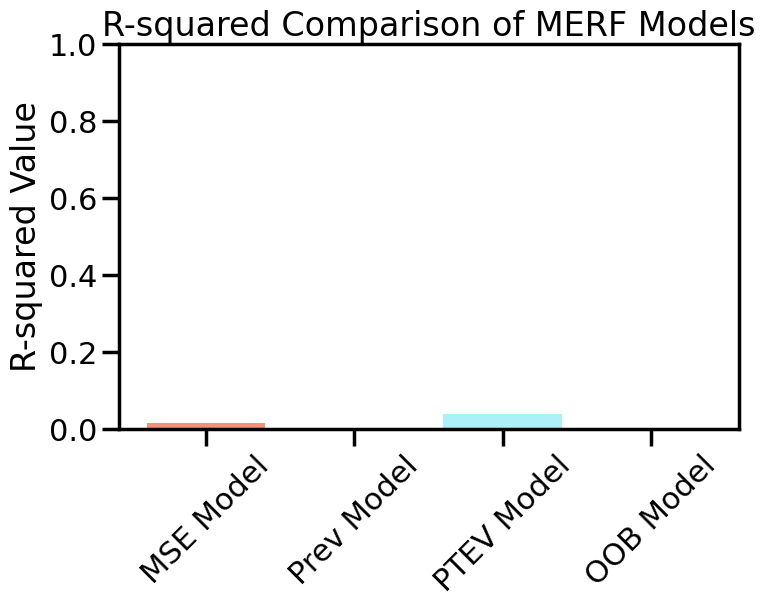

Best model: PTEV Model with R-squared: 0.0401


In [75]:
train_l = train_delta[basic]
test_l = test_delta[basic]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined/feb20"
r2_out = 'r2_only_meta_merf_bmi_delta_feb20.png'
feature_imp_out = 'fi_only_basic_merf_bmi_delta_feb20.png'
results_filename = 'merf_results_delta_only_basic_feb20.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])
print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    delta_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

## 2.1 Only Meta Delta 

In [ ]:
# Check for missing columns in train_delta
missing_columns = [col for col in meta_keep if col not in train_delta.columns]

if missing_columns:
    print("Missing columns in train_delta:", missing_columns)
else:
    print("All columns in meta_keep are present in train_delta.")

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter                2.00
n_splits                3.00
Name: 36, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits              10.00
Name: 14, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter              10.00
n_splits               3.00
Name: 21, dtype: float64
-----

INFO     [merf.py:307] Training GLL is -123.05949773546985 at iteration 1.
INFO     [merf.py:307] Training GLL is -176.8932567317044 at iteration 2.
INFO     [merf.py:307] Training GLL is -192.79990202889837 at iteration 3.
INFO     [merf.py:307] Training GLL is -200.83621425349153 at iteration 4.
INFO     [merf.py:307] Training GLL is -202.69302315408913 at iteration 5.
INFO     [merf.py:307] Training GLL is -206.52766360445082 at iteration 6.
INFO     [merf.py:307] Training GLL is -211.8209285510456 at iteration 7.
INFO     [merf.py:307] Training GLL is -214.12979014653257 at iteration 8.
INFO     [merf.py:307] Training GLL is -218.96023331635436 at iteration 9.
INFO     [merf.py:307] Training GLL is -220.8850040922645 at iteration 10.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:773: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wil

---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is -174.5921925302773 at iteration 1.
INFO     [merf.py:307] Training GLL is -248.4107827910568 at iteration 2.
INFO     [merf.py:307] Training GLL is -93.58142117846998 at iteration 1.


---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is -136.6615840422228 at iteration 2.


---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is -175.86537050131793 at iteration 1.
INFO     [merf.py:307] Training GLL is -252.54066515883625 at iteration 2.
INFO     [merf.py:307] Training GLL is -270.7085897424209 at iteration 3.
INFO     [merf.py:307] Training GLL is -274.6680655597428 at iteration 4.
INFO     [merf.py:307] Training GLL is -279.60863206850615 at iteration 5.
INFO     [merf.py:307] Training GLL is -286.46276053804394 at iteration 6.
INFO     [merf.py:307] Training GLL is -289.8551525365455 at iteration 7.
INFO     [merf.py:307] Training GLL is -295.70116083884164 at iteration 8.
INFO     [merf.py:307] Training GLL is -300.6507709969584 at iteration 9.
INFO     [merf.py:307] Training GLL is -303.78374457762254 at iteration 10.


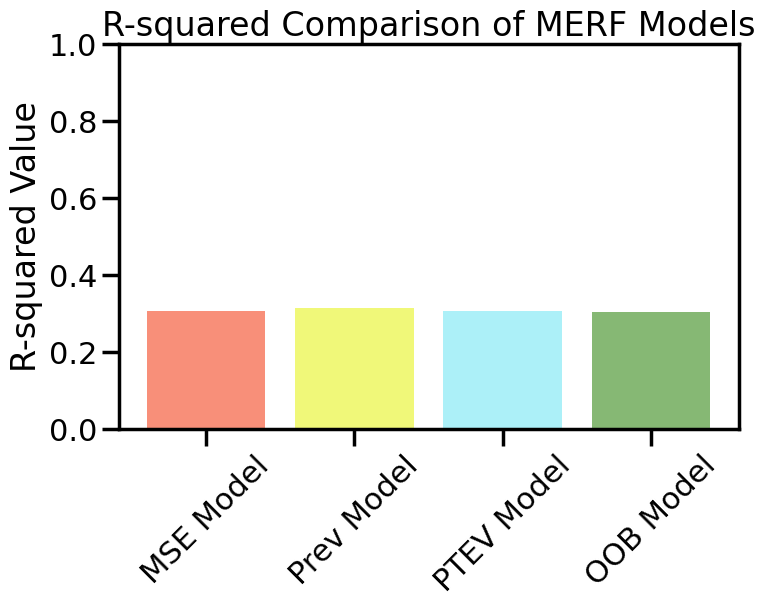

Best model: Prev Model with R-squared: 0.3133


In [76]:
train_l = train_delta[meta_keep]
test_l = test_delta[meta_keep]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined/feb20"
r2_out = 'r2_only_meta_merf_bmi_delta_feb20.png'
feature_imp_out = 'fi_only_meta_merf_bmi_delta_feb20.png'
results_filename = 'merf_results_delta_only_meta_feb20.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])
print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    delta_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

#### Only delta taxa

In [ ]:
# Check for missing columns in train_delta
missing_columns = [col for col in only_taxa if col not in train_delta.columns]

if missing_columns:
    print("Missing columns in train_delta:", missing_columns)
    print("taxa_cols:" , only_taxa)
else:
    print("All columns in only_taxa are present in train_delta.")

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter                2.00
n_splits                3.00
Name: 36, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits              10.00
Name: 14, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter              10.00
n_splits               3.00
Name: 21, dtype: float64
-----

INFO     [merf.py:307] Training GLL is -114.32006773923814 at iteration 1.
INFO     [merf.py:307] Training GLL is -177.83986911319198 at iteration 2.
INFO     [merf.py:307] Training GLL is -200.01747823867686 at iteration 3.
INFO     [merf.py:307] Training GLL is -212.31351076709387 at iteration 4.
INFO     [merf.py:307] Training GLL is -219.2463731331026 at iteration 5.
INFO     [merf.py:307] Training GLL is -225.77779497050463 at iteration 6.
INFO     [merf.py:307] Training GLL is -236.40671002790026 at iteration 7.
INFO     [merf.py:307] Training GLL is -243.4849938192384 at iteration 8.
INFO     [merf.py:307] Training GLL is -244.1079566981082 at iteration 9.
INFO     [merf.py:307] Training GLL is -248.9100407070183 at iteration 10.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:773: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will

---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is -155.04742008650226 at iteration 1.
INFO     [merf.py:307] Training GLL is -228.55506634844897 at iteration 2.


---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is -87.97443996524217 at iteration 1.
INFO     [merf.py:307] Training GLL is -130.88357138985566 at iteration 2.


---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is -151.7069537615606 at iteration 1.
INFO     [merf.py:307] Training GLL is -226.4910621028165 at iteration 2.
INFO     [merf.py:307] Training GLL is -251.8726939056133 at iteration 3.
INFO     [merf.py:307] Training GLL is -262.88484684881934 at iteration 4.
INFO     [merf.py:307] Training GLL is -267.138636664439 at iteration 5.
INFO     [merf.py:307] Training GLL is -276.9328517197196 at iteration 6.
INFO     [merf.py:307] Training GLL is -286.07320603125913 at iteration 7.
INFO     [merf.py:307] Training GLL is -288.8594245165044 at iteration 8.
INFO     [merf.py:307] Training GLL is -294.75434091462085 at iteration 9.
INFO     [merf.py:307] Training GLL is -301.1902990355065 at iteration 10.


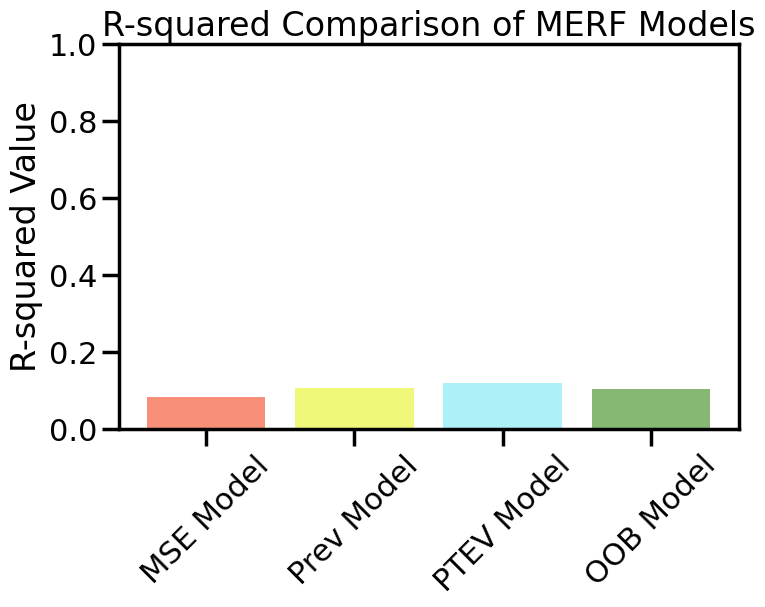

Best model: PTEV Model with R-squared: 0.1184


In [77]:
train_l = train_delta[only_taxa]
test_l = test_delta[only_taxa]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined/feb20"
r2_out = 'r2_meta_taxa_merf_bmi_delta_feb20.png'
feature_imp_out = 'fi_meta_taxa_merf_bmi_delta_feb20.png'
results_filename = 'merf_results_delta_only_meta_taxa_feb20.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])
print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    delta_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

#### Only micom delta

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter                2.00
n_splits                3.00
Name: 36, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits              10.00
Name: 14, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter              10.00
n_splits               3.00
Name: 21, dtype: float64
-----

INFO     [merf.py:307] Training GLL is -88.05112741141878 at iteration 1.
INFO     [merf.py:307] Training GLL is -137.74614678477454 at iteration 2.
INFO     [merf.py:307] Training GLL is -151.89625783893547 at iteration 3.
INFO     [merf.py:307] Training GLL is -163.9915543683896 at iteration 4.
INFO     [merf.py:307] Training GLL is -173.20229775587052 at iteration 5.
INFO     [merf.py:307] Training GLL is -184.61314216291987 at iteration 6.
INFO     [merf.py:307] Training GLL is -190.8975438393213 at iteration 7.
INFO     [merf.py:307] Training GLL is -197.3177050146365 at iteration 8.
INFO     [merf.py:307] Training GLL is -204.46728758820478 at iteration 9.
INFO     [merf.py:307] Training GLL is -210.20402169428453 at iteration 10.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:773: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will

---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is -127.28666838137205 at iteration 1.
INFO     [merf.py:307] Training GLL is -192.69860421681534 at iteration 2.


---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is -44.010645414358954 at iteration 1.
INFO     [merf.py:307] Training GLL is -78.50674140452062 at iteration 2.


---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is -127.73749363489063 at iteration 1.
INFO     [merf.py:307] Training GLL is -190.1822430368863 at iteration 2.
INFO     [merf.py:307] Training GLL is -209.21916544831234 at iteration 3.
INFO     [merf.py:307] Training GLL is -215.12136733744978 at iteration 4.
INFO     [merf.py:307] Training GLL is -227.1191815116308 at iteration 5.
INFO     [merf.py:307] Training GLL is -231.78503464966778 at iteration 6.
INFO     [merf.py:307] Training GLL is -236.9585023001613 at iteration 7.
INFO     [merf.py:307] Training GLL is -239.84370656451847 at iteration 8.
INFO     [merf.py:307] Training GLL is -246.43084949719872 at iteration 9.
INFO     [merf.py:307] Training GLL is -252.45666192922698 at iteration 10.


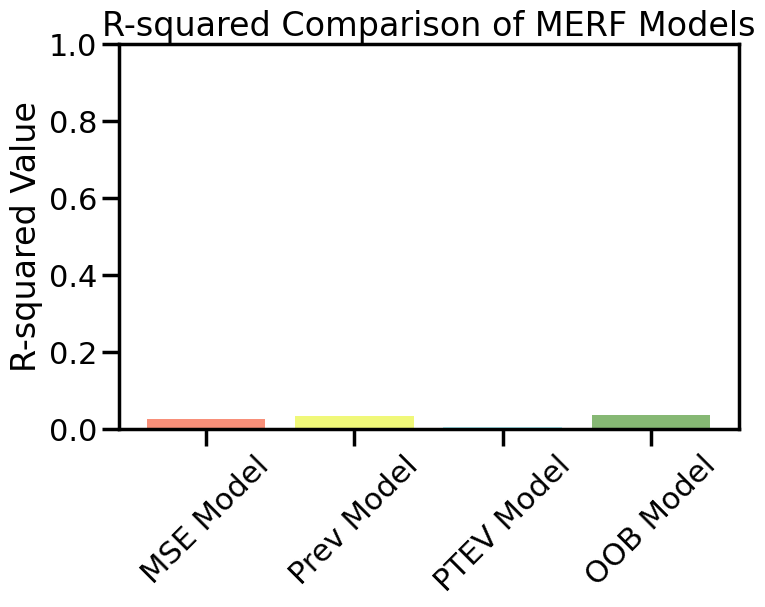

Best model: OOB Model with R-squared: 0.0355


In [78]:
train_l = train_delta[only_micom]
test_l = test_delta[only_micom]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined/feb20"
r2_out = 'r2_micom_merf_bmi_delta_feb20.png'
feature_imp_out = 'fi_micom_merf_bmi_delta_feb20.png'
results_filename = 'merf_results_delta_only_micom_feb20.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])
print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    delta_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

#### Only pathway delta

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter                2.00
n_splits                3.00
Name: 36, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits              10.00
Name: 14, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter              10.00
n_splits               3.00
Name: 21, dtype: float64
-----

INFO     [merf.py:307] Training GLL is -111.53992706375901 at iteration 1.
INFO     [merf.py:307] Training GLL is -160.31129175941257 at iteration 2.
INFO     [merf.py:307] Training GLL is -175.33637655103823 at iteration 3.
INFO     [merf.py:307] Training GLL is -188.6939753087678 at iteration 4.
INFO     [merf.py:307] Training GLL is -197.35308805003552 at iteration 5.
INFO     [merf.py:307] Training GLL is -203.34629171244276 at iteration 6.
INFO     [merf.py:307] Training GLL is -206.7796477898291 at iteration 7.
INFO     [merf.py:307] Training GLL is -211.37885733602673 at iteration 8.
INFO     [merf.py:307] Training GLL is -213.82195367098248 at iteration 9.
INFO     [merf.py:307] Training GLL is -222.74661549801652 at iteration 10.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:773: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wi

---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is -151.0162539182317 at iteration 1.
INFO     [merf.py:307] Training GLL is -223.53628684509334 at iteration 2.


---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is -76.91278602018414 at iteration 1.
INFO     [merf.py:307] Training GLL is -113.14010658740554 at iteration 2.


---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is -150.4129860949345 at iteration 1.
INFO     [merf.py:307] Training GLL is -224.91257801112482 at iteration 2.
INFO     [merf.py:307] Training GLL is -239.3356708840184 at iteration 3.
INFO     [merf.py:307] Training GLL is -245.62230014229954 at iteration 4.
INFO     [merf.py:307] Training GLL is -252.37343445800173 at iteration 5.
INFO     [merf.py:307] Training GLL is -256.16981444581546 at iteration 6.
INFO     [merf.py:307] Training GLL is -258.8997559327266 at iteration 7.
INFO     [merf.py:307] Training GLL is -265.91871079810676 at iteration 8.
INFO     [merf.py:307] Training GLL is -267.4257923925214 at iteration 9.
INFO     [merf.py:307] Training GLL is -269.5442241790103 at iteration 10.


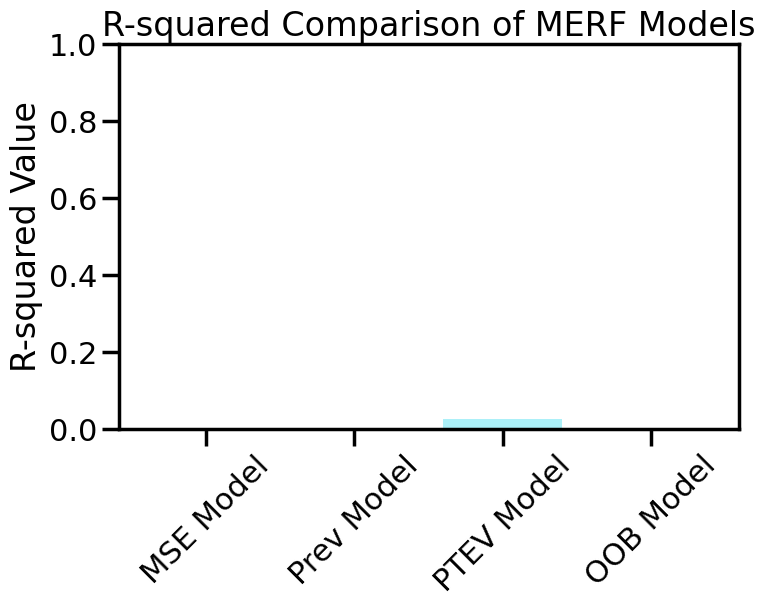

Best model: PTEV Model with R-squared: 0.0266


In [80]:
train_l = train_delta[only_pathway]
test_l = test_delta[only_pathway]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined/feb20"
r2_out = 'r2_pathway_merf_bmi_delta_feb20.png'
feature_imp_out = 'fi_pathway_merf_bmi_delta_feb20.png'
results_filename = 'merf_results_delta_only_pathway_feb20.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])
print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    delta_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

## 2.2 Ok now include meta and taxa deltas 

There is no change in bmi_prs so that is not included in the delta models 

In [ ]:
train_l = train_delta[meta_grs_taxa]
test_l = test_delta[meta_grs_taxa_test]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined"
r2_out = 'r2_meta_taxa_merf_bmi_delta_feb12.png'
feature_imp_out = 'fi_meta_taxa_merf_bmi_delta_feb12.png'
results_filename = 'merf_results_delta_only_meta_taxa_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    delta_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

## 2.3 Delta variables Meta + Taxa + Functional

In [18]:
train_l = train_delta[meta_grs_taxa]
test_l = test_delta[meta_grs_taxa_test]

# Check for duplicate column names in train_l and test_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()

# Count of duplicate columns
num_duplicates_train = len(duplicates_train)
num_duplicates_test = len(duplicates_test)

# Remove duplicate columns from train_l
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
test_l = test_l.loc[:, ~test_l.columns.duplicated()]

In [ ]:
train_l = train_delta[meta_grs_taxa_functional]
test_l = test_delta[meta_grs_taxa_functional_test]

# Check for duplicate column names in train_l and test_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()

# Count of duplicate columns
num_duplicates_train = len(duplicates_train)
num_duplicates_test = len(duplicates_test)

# Remove duplicate columns from train_l
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
test_l = test_l.loc[:, ~test_l.columns.duplicated()]

print("Columns in train_l DataFrame:")
print(list(train_l.columns))  # Convert to list for better readability

In [ ]:
train_l = train_delta[meta_grs_taxa_functional]
test_l = test_delta[meta_grs_taxa_functional_test]

# Check for duplicate column names in train_l and test_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()

# Count of duplicate columns
num_duplicates_train = len(duplicates_train)
num_duplicates_test = len(duplicates_test)

# Remove duplicate columns from train_l
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
test_l = test_l.loc[:, ~test_l.columns.duplicated()]

output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined"
r2_out = 'r2_meta_taxa_functional_merf_bmi_delta_feb12.png'
feature_imp_out = 'fi_meta_taxa_functional_merf_bmi_delta_feb12.png'
results_filename = 'merf_results_delta_meta_taxa_functional_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])
print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    delta_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

## 2.4 all delta omics except meta 

In [ ]:


print("test longitudinal: ", list(test_l.columns))
print("train longitudinal: ", list(train_l.columns))

# Print duplicated column names in test_l
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()
print("Duplicated columns in test_l: ", duplicates_test)

# Print duplicated column names in train_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
print("Duplicated columns in train_l: ", duplicates_train)


In [ ]:
train_l = train_delta.drop(all_but_meta, axis = 1)
test_l = test_delta.drop(all_but_meta, axis = 1)

output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined"
r2_out = 'r2_taxa_functional_micom_merf_bmi_delta_feb12.png'
feature_imp_out = 'fi_taxa_functional_micom_merf_bmi_delta_feb12.png'
results_filename = 'merf_results_delta_taxa_functional_micom_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI','subject_id', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    delta_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

## 2.5 all delta varibles 

In [ ]:
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined"
r2_out = 'r2_all_omic_merf_bmi_delta_feb12.png'
feature_imp_out = 'fi_all_omic_merf_bmi_delta_feb12.png'
results_filename = 'merf_results_delta_all_omic_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_delta
X = train_set.drop(['BMI','Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_delta
X_new = test_set.drop(['BMI','Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])
print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

#r2_delta_run5 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             delta_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    delta_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

# Now you can use `top_features` for plotting or further analysis

# Comparing all models above 

In [21]:
def compare_r2_values1(model_names, *r2_dicts):
    # Create a DataFrame to hold the R-squared values
    r2_comparison_df = pd.DataFrame(r2_dicts).T
    r2_comparison_df.columns = model_names 
    print(r2_comparison_df.head(10).columns[:10])
    print(r2_comparison_df.head(10))

    # Sort the DataFrame by R-squared values in descending order
    r2_comparison_df = r2_comparison_df.sort_values(by=model_names, ascending=False)

    # Set up the bar positions
    num_runs = len(r2_comparison_df.columns)
    bar_width = 0.15  # Width of each bar
    x = np.arange(len(r2_comparison_df))  # The label locations

    # Create a color map for the models
    colors = plt.cm.viridis(np.linspace(0, 1, num_runs))

    # Create bars for each model in each run
    for i in range(num_runs):
        plt.bar(x + i * bar_width, r2_comparison_df.iloc[:, i],  # Use plt.bar for vertical bars
                 width=bar_width, label=model_names[i], color=colors[i])  # Use model names for labels

    # Add labels, title, and custom x-axis tick labels
    plt.ylabel('R-squared Value')  # Change to y-label
    plt.title('R-squared Comparison of Different Runs')
    plt.ylim(0, 0.55)  # Assuming R-squared values are between 0 and 1
    plt.xticks(x + bar_width * (num_runs - 1) / 2, r2_comparison_df.index)  # Center the x-ticks
    plt.legend(title='Models', loc='upper right', fontsize=10, 
               title_fontsize=10, ncol = 2, frameon=False)
    plt.tight_layout()
    plt.show()

In [ ]:
model_names = ['Only Meta', 'Meta GRS', 
               'Meta GRS Tax', 'Meta GRS Tax Func', 
               'All But Meta', 'All Omic']
compare_r2_values1(model_names, r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6)

In [ ]:
model_names_delta = ['Only Meta Delta',  
               'Meta Tax Delta', 'Meta Tax Func Delta', 
               'All But Meta Delta', 'All Omic Delta']
compare_r2_values1(model_names_delta, r2_delta_run1, r2_delta_run2, 
                   r2_delta_run3, r2_delta_run4, r2_delta_run5)

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_r2_values2(model_names, *r2_dicts):
    # Create a DataFrame to hold the R-squared values
    r2_comparison_df = pd.DataFrame(r2_dicts).T
    r2_comparison_df.columns = model_names 

    # Reset index to use row names as a column
    r2_comparison_df.reset_index(inplace=True)
    r2_comparison_df = r2_comparison_df.melt(id_vars='index', var_name='Model', value_name='R-squared')

    # Rename the 'index' column to 'Metric' for clarity
    r2_comparison_df.rename(columns={'index': 'Metric'}, inplace=True)

    # Create the bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=r2_comparison_df, x='Model', y='R-squared', hue='Metric', palette='viridis')

    # Add labels and title
    plt.ylabel('R-squared Value')
    plt.title('R-squared Comparison of Different Models')
    plt.ylim(0.0, 0.35)  # Adjust y-limits based on your data range
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='hyperparameter optimization settings', loc='upper right', fontsize=9, 
               title_fontsize=8, ncol = 4, frameon=False)
    plt.tight_layout()
    plt.show()

In [ ]:
model_names = ['Only Meta', 'Meta GRS', 
               'Meta GRS Tax', 'Meta GRS Tax Func', 
               'All But Meta', 'All Omic']
compare_r2_values2(model_names, r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6)

In [ ]:
compare_r2_values2(model_names_delta, r2_delta_run1, r2_delta_run2, 
                   r2_delta_run3, r2_delta_run4, r2_delta_run5)

In [ ]:
model_names_both = ['Only Meta Long', 'Meta GRS Long', 
               'Meta GRS Tax Long', 'Meta GRS Tax Func Long', 
               'All But Meta Long', 'All Omic Long', 
               'Only Meta Delta', 'Meta Tax Delta', 'Meta Tax Func Delta', 
               'All But Meta Delta', 'All Omic Delta']

compare_r2_values2(model_names_both, 
                   r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6,
                   r2_delta_run1, r2_delta_run2, 
                   r2_delta_run3, r2_delta_run4, r2_delta_run5)

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_r2_values3(model_names, *r2_dicts):
    # Create a DataFrame to hold the R-squared values
    r2_comparison_df = pd.DataFrame(r2_dicts).T
    r2_comparison_df.columns = model_names 

    # Reset index to use row names as a column
    r2_comparison_df.reset_index(inplace=True)
    r2_comparison_df = r2_comparison_df.melt(id_vars='index', var_name='Model', value_name='R-squared')

    # Rename the 'index' column to 'Metric' for clarity
    r2_comparison_df.rename(columns={'index': 'Metric'}, inplace=True)

    # Sort the DataFrame by 'Model' and then by 'R-squared' in descending order
    r2_comparison_df = r2_comparison_df.sort_values(by=['Metric', 'R-squared'], ascending=[True, False])

    # Create the bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=r2_comparison_df, x='Model', y='R-squared', hue='Metric', palette='viridis')

    # Add labels and title
    plt.ylabel('R-squared Value')
    plt.title('R-squared Comparison of Different Models')
    plt.ylim(-0.2, 0.2)  # Adjust y-limits based on your data range
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='hyperparameter optimization settings', loc='upper right', fontsize=10, 
               title_fontsize=10, ncol = 2, frameon=False)
    plt.tight_layout()
    plt.show()

In [ ]:
model_names = ['Only Meta', 'Meta GRS', 
               'Meta GRS Tax', 'Meta GRS Tax Func', 
               'All But Meta', 'All Omic']
compare_r2_values3(model_names, r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance(dataframes):
    # Combine all DataFrames into a single DataFrame
    combined_df = pd.concat(dataframes)
    
    # Create a plot
    plt.figure(figsize=(12, 8))
    bar_width = 0.08
    # Plot each model's feature importance
    for model in combined_df['Model'].unique():
        model_data = combined_df[combined_df['Model'] == model]
        plt.bar(model_data['Feature'], model_data['Importance'], label=model)
    
    # Add labels and title
    plt.xlabel('Features', fontsize=10)
    plt.ylabel('Importance', fontsize=10)
    plt.title('Feature Importance by Model')
    plt.xticks(rotation=45, fontsize=9)
    plt.legend(title='Model', fontsize=9, ncol=2)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example usage
feature_importance_dfs = [fi_run1, fi_run2, fi_run3, fi_run4, fi_run5, fi_run6, fi_delta_run1, fi_delta_run2]
plot_feature_importance(feature_importance_dfs)

In [78]:
def plot_feature_importance(dataframes):
    combined_df = pd.concat(dataframes) # Combine all DataFrames 
    # Filter features with importance < 0.02 & negative importance in all models
    combined_df = combined_df[(combined_df['Importance'] >= 0.02) & 
                          (combined_df.groupby('Feature')['Importance'].transform('min') >= 0)]
    plt.figure(figsize=(12, 8))
    bar_width = 0.15 
    num_models = len(combined_df['Model'].unique())
    
    # Get unique features
    features = combined_df['Feature'].unique()
    x = np.arange(len(features))  # The label locations

    # Plot each model's feature importance
    for i, model in enumerate(combined_df['Model'].unique()):
        model_data = combined_df[combined_df['Model'] == model]
        
        # Ensure heights only includes matching features
        heights = model_data[model_data['Feature'].isin(features)]['Importance'] 
        model_x = x[:len(heights)] + i * bar_width  # Adjust x-coordinates for the current model
        plt.bar(model_x, heights, width=bar_width, label=model)
    
    # Add labels and title
    plt.xlabel('Features', fontsize=10)
    plt.ylabel('Importance', fontsize=10)
    plt.title('Feature Importance by Model')
    plt.xticks(x + bar_width * (num_models - 1) / 2, features, rotation=45, fontsize=9)  # Center x-ticks
    plt.legend(title='Model', fontsize=9, ncol=2)
    plt.tight_layout()
    plt.ylim(0, 0.6)
    plt.show()

In [81]:
def plot_feature_importance(dataframes, model_labels):
    combined_df = pd.concat(dataframes)  # Combine all DataFrames 
    # Filter features with importance < 0.02 & negative importance in all models
    combined_df = combined_df[(combined_df['Importance'] >= 0.02) & 
                              (combined_df.groupby('Feature')['Importance'].transform('min') >= 0)]
    plt.figure(figsize=(12, 8))
    bar_width = 0.15 
    num_models = len(combined_df['Model'].unique())
    
    # Get unique features
    features = combined_df['Feature'].unique()
    x = np.arange(len(features))  # The label locations

    # Plot each model's feature importance
    for i, model in enumerate(combined_df['Model'].unique()):
        model_data = combined_df[combined_df['Model'] == model]
        
        # Ensure heights only includes matching features
        heights = model_data[model_data['Feature'].isin(features)]['Importance'] 
        model_x = x[:len(heights)] + i * bar_width  # Adjust x-coordinates for the current model
        plt.bar(model_x, heights, width=bar_width, label=model_labels[i])  # Use custom labels
    
    # Add labels and title
    plt.xlabel('Features', fontsize=10)
    plt.ylabel('Importance', fontsize=10)
    plt.title('Feature Importance by Model')
    plt.xticks(x + bar_width * (num_models - 1) / 2, features, rotation=45, fontsize=9)  # Center x-ticks
    plt.legend(title='Model', fontsize=9, ncol=2)
    plt.tight_layout()
    plt.ylim(0, 0.6)
    plt.show()

In [83]:
model_labels_long = ['Only Meta', 'Meta GRS', 'Meta GRS Tax', 'Meta GRS Tax Func', 'All But Meta', 'All Omic']
model_labels_delta = ['Only Meta Delta', 'Meta Tax Delta', 'Meta Tax Func Delta', 'All But Meta Delta', 'All Omic Delta']
fi_long = [fi_run1, fi_run2, fi_run3, fi_run3, fi_run4, fi_run5, fi_run6]
fi_delta = [fi_delta_run1, fi_delta_run2, fi_delta_run3, fi_delta_run4, fi_delta_run5]

In [ ]:
plot_feature_importance(fi_long, model_labels_long)

In [ ]:
plot_feature_importance(fi_delta, model_labels_delta)